# Principal Component Analysis and KMeans for Tap Testing 
This code is roughly translated from Piedad Miranda's MATLab code

### Importing the necessary libraries for PCA, KMeans, and Audio manipulation

In [49]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np

Functions for extracting data from .wav files


In [50]:
# Parameters:
# audio_file : inputted audio file to be read
# Return values: 
# sample rate : the sample rate extracted from the file
# data : the data read from the WAV file
def audioread(audio_file):
    sample_rate, data = wavfile.read(audio_file)
    return sample_rate, data

# Becuase the .wav values are between -32768 and 32767, we need to output 
# our normalize them to be between -1 and 1
def normalize(data):
    return data.astype(np.float32) / 32728

In [51]:
Fs, x = audioread("audios/000416_0108S12_badCond_noMov.wav")

# checking to see if mono
if x.ndim == 1:
    right_channel = x 
else: 
    right_channel = x[:,1]

print(f"Sampling Rate: {Fs}")
print(f"Amount of samples: {len(x)}")
print(f"First 15 samples of .wav file: {right_channel[:15]}")

# here we are going to normalize so that the values range between -1 and 1
normalized_right_channel = normalize(right_channel)
print(f"First 15 samples of normalized data: {normalized_right_channel[:15]}")

Sampling Rate: 44100
Amount of samples: 3987072
First 15 samples of .wav file: [-688 -720 -758 -763 -778 -823 -839 -813 -805 -829 -852 -847 -795 -794
 -861]
First 15 samples of normalized data: [-0.02102176 -0.02199951 -0.0231606  -0.02331337 -0.02377169 -0.02514666
 -0.02563554 -0.02484111 -0.02459668 -0.02532999 -0.02603276 -0.02587998
 -0.02429113 -0.02426057 -0.02630775]


For 16 bit audio, we should be able to see values between -32768 to 32767 becuase (2^16) - 1 is 65535. 

In [52]:
# Here we are creating a time vector corresponding to the audio samples in x
# it starts at time 0 and creates equal partitions between end time at Ts = 1/Fs
time_vector = np.arange(0,len(x) / Fs, 1 / Fs)
print(len(time_vector))

3987072


In [116]:
# We now implement a variable for downsampling just in case we 
# want to downsample in the future
down_sample = 1

# downsampled signal
y = normalized_right_channel[::down_sample]

# downsampled time vector to match
ds_time_vector = time_vector[::down_sample]
print(len(ds_time_vector))


3987072


We are plotting the amplitude vs time (downsampled for more clarity) of the first 2 seconds of the sample.

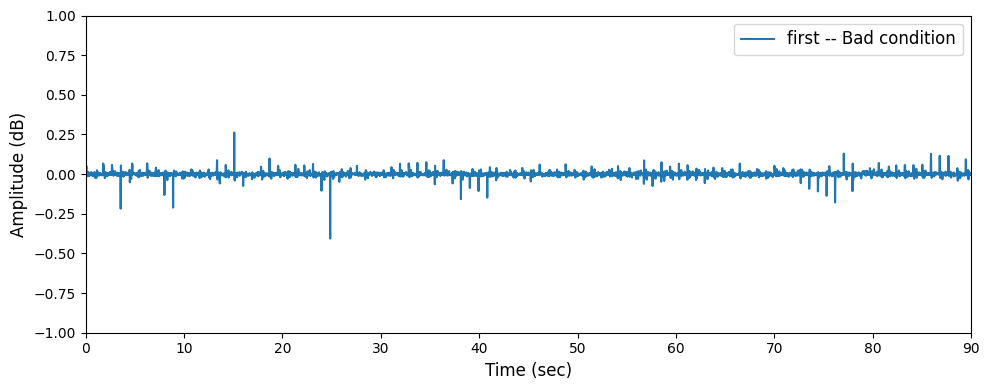

In [123]:
plt.figure(figsize=(10,4))
plt.plot(time_vector[::1000], y[::1000], label=r'first -- Bad condition')

plt.xlim(0,90)
plt.ylim(-1,1)

plt.xlabel(r'Time (sec)', fontsize=12)
plt.ylabel(r'Amplitude (dB)', fontsize=12)

plt.legend(fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

In the graph above, we can see the first two taps as their amplitude rises and falls. The more dampened the signal (the longer it takes for the sample to fall back to 0 amplitude), the higher probability the that the sample is spalled or cracked internally. Below we have a more zoomed in perspective that allows us to see the first tap on the bad concrete sample.  

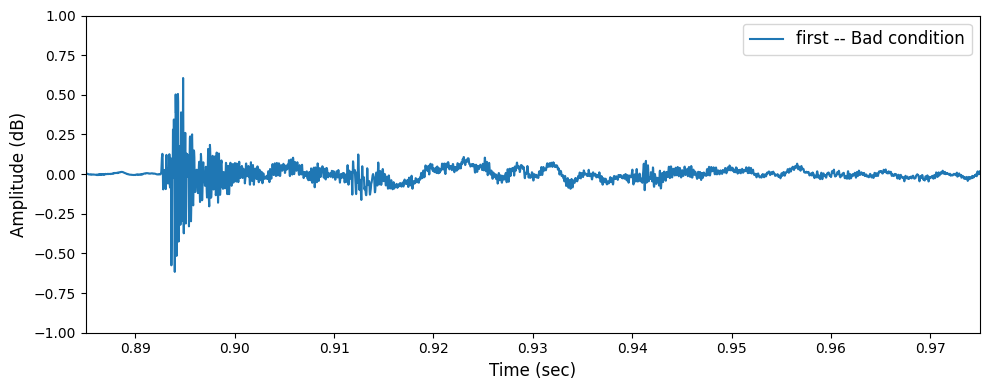

In [102]:
plt.figure(figsize=(10,4))
plt.plot(ds_time_vector, y, label=r'first -- Bad condition')

plt.xlim(0.885,0.975)
plt.ylim(-1,1)

plt.xlabel(r'Time (sec)', fontsize=12)
plt.ylabel(r'Amplitude (dB)', fontsize=12)

plt.legend(fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

Now we can define a tap at regular intervals of 1 second by disregarding peaks that occur within 0.5 seconds of each other.

In [108]:
from scipy.signal import find_peaks

def find_peaks_with_time(y, time, min_peak_distance_sec):
    # calculate distance in number of samples
    change_in_time = time[1] - time[0]
    print(change_in_time)
    min_peak_distance_samples = int(min_peak_distance_sec / change_in_time)
    print(min_peak_distance_samples)

    # Find peaks
    peak_indices, _ = find_peaks(y, distance=min_peak_distance_samples)

    # map indices to time and amplitudes
    peak_times = time[peak_indices]
    peak_values = y[peak_indices]

    return peak_values, peak_times

peak_values, peak_times = find_peaks_with_time(y, ds_time_vector, min_peak_distance_sec=0.5) 

2.2675736961451248e-05
22050


Next, filter the peaks to keep only those whose amplitudes fit between our lower threshold and 1 (in dB)

In [110]:
# Our threshold
threshold = 0.1

filtered_peaks = np.where((peak_values > threshold) & (peak_values < 1))[0]
filtered_peak_times = peak_times[filtered_peaks]
print(len(filtered_peak_times))

103


We want to make a matrix of these 'taps' so that we can train our algorithm on these good and bad samples

In [113]:
peak_index = [np.argmin(np.abs(ds_time_vector - loc)) for loc in filtered_peak_times]

taps = [y[i:i+101] for i in peak_index]

taps_matrix = np.vstack(taps)

print(np.shape(taps_matrix))

(103, 101)
